In [1]:
import networkx as nx
import matplotlib.pyplot as plt
import networkx as nx
import matplotlib.pyplot as plt
import random
from itertools import combinations, groupby
from scipy.optimize import minimize
from qiskit import Aer
from qiskit.algorithms.optimizers import COBYLA
from qiskit.visualization import plot_histogram
from scipy.optimize import minimize
from qiskit.circuit import Gate
from qiskit import QuantumCircuit , QuantumRegister
from qiskit.tools.visualization import circuit_drawer
from qiskit.circuit import Parameter


# Unit commitment Problem 

Unit commitment(UC) problem is a fundamental nonlinear non-convex NP-hard optimization problem which makes finding optimal solution difficult. The problem is usually modeled as a mixed-integer programming. The objective of UC problem is to achieve a common target given a set of generating units  subject to  a set of constraints.

The importance of the problem is reflected on the large different approaches suggested to solve the problem which requires requires fast decisions. Quantum computers may provide and advantage in this case.


## Problem Statement

The problem of Unit Commitment deals with what generators should be turned on/off and when depending on the demand so as to minimize costs.

 The setup is as follows. We have a power grid with various power generation units(nodes) that are connected by transmission lines. For simplicity, we assume that we have a set of nodes with one load. The transmission costs is identical(no edges in this case). To simplify the problem even furhter, we only consider one time step. Each node has a set of physical characterisctis: 
 
 A: fixed cost of the unit when it is turned on regardless of the power level.
 
 B: linear cost based on the power level.
 
 C: quandratic cost based on the power level.
 
 Total cost per unit: $C(P) = A + B*P + C* P^2$ where $P$ is the allocatated power to the unit. Classical methods are used to find this paparmeter like economic dispatch.  The total cost is  the sum of the costs of the units that are on.

 
 
 $P_{min}$: minimum generation limit.
 
 $P_{max}$: maximum generation limit.
 
There are many other operational parameters that can be added easily. For simplicity, we consider these. Fig. 1 demonstrates two ways that the load of a 4-unit system could be met while keeping within each unit’s
constraints, and gives the cost of each configuration [[1]](https://arxiv.org/abs/2110.12624).


![alt text](./images/uc.jpg "ref[]")



Thus the  variant we are dealing with can be formulated as the following binary problem:

$$
\begin{aligned}
 min & \sum_{i=1}^{n} y_i C_i(P) = \sum_{i=1}^{n}(y_i(A_i + B_i*P_i + C_i* P_{i}^{2}))\\
  \text{subject to} & \\
&\sum_{i=1}^{n} P_i = L \\
& P_{min,i}  \leq P_i y_i \leq P_{max,i}\\
\end{aligned}
$$

Here, $y_i$ is a binary variable representing the state of the i-th generator ; 1 if on, 0 if
off. $A_i,B_i , C_i$ are constants ,  $P_i  \in \mathbb{R}$. $L$ is the load.

Following [[1]](https://arxiv.org/abs/2110.12624), we convert the constrained equation above into unconstrained one adding some penalty terms:


$$
\begin{aligned}
 min & \sum_{i=1}^{n} y_i C_i(P) = \sum_{i=1}^{n}((A_i*y_i + B_i*P_i + C_i* P_{i}^{2}))\\
  \text{subject to} & \\
&\sum_{i=1}^{n} \lambda_1 * y_i(P_i -L )^{2} \\
&  \lambda_2 * (P_i -  s_{1,i} -  P_{min,i}*y_i)^{2} \\
&  \lambda_3 * (P_i +  s_{2,i} -  P_{max,i}*y_i)^{2} \\
\end{aligned}
$$

where $\lambda_1 , \lambda_2 , \lambda_3$ are some empirical constant , $s_{1,i} ,s_{2,i}$ are some penalty terms found by some classical optimizer.


## Algorithm overview

We use QAOA to handle the problem of whether the unit is one or off and classical optimzer to handle the continuous variables $\gamma_{j}$ , $\beta_{j}$ and $P_{i}$ for $j = 1,2,...,p$ , for $i = 1,2,...,n$ where $n$ is the number of generating units and $p$ is the depth of the circuit. Our main task then would be to construct the cost layer( problem Hamiltonian ). For mixing Hamiltonian,  We will just use the default mixer layer with $R_X$ gates.

Let the input bitstring represent $y$. The i-th qubit  will represent whether the i-th generator is on (|1⟩) or off (|0⟩). The function of a cost layer  is to take this input state and add a phase to it, with the phase angle being the cost of the input state times some $\gamma_{i}$.

We need convert  binary variables $y_i \in \{0, 1\}$ to $z_i \in \{+1, −1\}$  by using the transformation $z_i = 2y_i − 1$ to comply with the standard form for QUBOs solved by QAOA.

[These Cost and Mixing Hamiltonian steps are repeated $P$ times before terminating measurements on each qubit.]

The problem Hamiltonian specific to the above problem is:

$$
\begin{aligned}
H_p & = TODO \\
U(H_p) &= e^{-i\gamma H_p} = TODO
\end{aligned}
$$

In [2]:

class Node:

    def __init__(self, A, B, C, minCapacity , maxCapacity):
        self.A = A
        self.B = B
        self.C = C
        self.minCapacity = minCapacity
        self.maxCapacity = maxCapacity
        
    def cost(self , p):
        assert p >= self.minCapacity , "power should be greater than minimum power"
        assert p <= self.maxCapacity, "power should be smaller than maximum power"
        
        return (self.A + self.B*p + self.C * p**2)
    

nodes  = []
### using the  example in the paper Figure (1)
nodes.append(Node(30,25,100 , 100 , 300))
nodes.append(Node(50,10,80  , 100 , 300))
nodes.append(Node(20,30,120 , 500 , 900))
nodes.append(Node(20,20,70  , 0 , 900))
random.seed(1)

nqubits = len(nodes)

G = nx.Graph()

G.add_nodes_from([i for i in range(nqubits)])


In [3]:

### initial power values
power = [250 , 250 , 500 , 0.0]
weights_nodes = []

for nn in range(0,len(nodes)):
    weights_nodes.append( -1.0 *nodes[nn].cost(power[nn]))
    G.add_nodes_from([(nn,{'weight':  weights_nodes[nn]})])
    
weights_edges = [1,1,1,1]


edges = combinations(range(len(nodes)), 2)
iter=0
for _, node_edges in groupby(edges, key=lambda x: x[0]):
    node_edges = list(node_edges)
    random_edge = random.choice(node_edges)
    G.add_edges_from([(random_edge[0], random_edge[1],{'weight': weights_edges[iter]})])
    iter += 1

    for e in node_edges:
        if random.random() < 0.4:
            G.add_edges_from([(e[0], e[1],{'weight': weights_edges[iter]})])
            iter += 1

#plt.figure(figsize=(8,5))
#nx.draw(G, node_color='lightblue',with_labels=True, node_size=500)


### The Initial State

We use the default initial state of the QAOA

$$\lvert \psi_0 \rangle = \bigg(\frac{1}{\sqrt{2}}\big(\lvert 0 \rangle + \lvert 1 \rangle\big)\bigg)^{\otimes n}$$


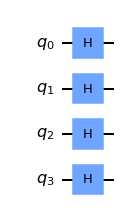

In [4]:
qc_0 = QuantumCircuit(nqubits)
for i in range(0, nqubits):
    qc_0.h(i)
    
qc_0.draw("mpl")

### The Mixing Unitary

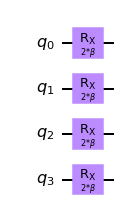

In [5]:


beta = Parameter("$\\beta$")
qc_mix = QuantumCircuit(nqubits)
for i in range(0, nqubits):
    qc_mix.rx(2 * beta, i)
    
qc_mix.draw("mpl")

### The Problem Unitary

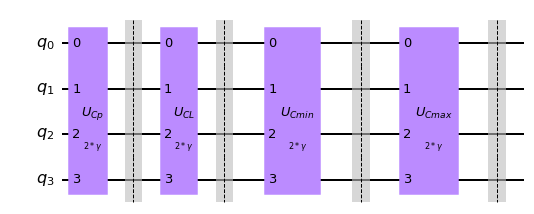

In [6]:
    ## all this represent cost layer
gamma = Parameter("$ 2* \\gamma$")
qc_p = QuantumCircuit(nqubits)
qr = QuantumRegister(nqubits, 'q')

Cp = Gate(name="$U_{Cp}$", num_qubits=4, params=[gamma])
CL = Gate(name="$U_{CL}$", num_qubits=4, params=[gamma])
Cmin = Gate(name="$U_{Cmin}$", num_qubits=4, params=[gamma])
Cmax = Gate(name="$U_{Cmax}$", num_qubits=4, params=[gamma])

qc_p.append(Cp , qr)
qc_p.barrier()

qc_p.append(CL , qr)
qc_p.barrier()

qc_p.append(Cmin , qr)
qc_p.barrier()

qc_p.append(Cmax , qr)
qc_p.barrier()

qc_p.draw("mpl")

where $Cp$ corresponds to the first term of the cost function above, $CL$ , $Cmin$ and $Cmax$ correspond to the following constraints. 

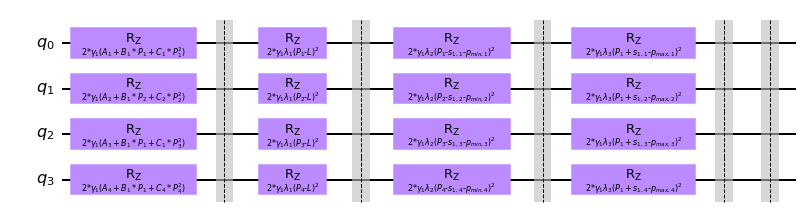

In [7]:
## A brute-Force circuit :)

qr = QuantumRegister(nqubits, 'q')
qc_p = QuantumCircuit(qr)

# Add the first cost circuit
gammacp1 = Parameter("$  \\gamma_1 (A_1 + B_1*P_1 + C_1* P_{1}^{2})$")
qc_p.rz(2 * gammacp1, qr[0])

gammacp2 = Parameter("$  \\gamma_1 (A_2 + B_1*P_2 + C_2* P_{2}^{2})$")
qc_p.rz(2 * gammacp2, qr[1])

gammacp3 = Parameter("$  \\gamma_1 (A_3 + B_1*P_1 + C_1* P_{3}^{2})$")
qc_p.rz(2 * gammacp3, qr[2])

gammacp4 = Parameter("$  \\gamma_1 (A_4 + B_1*P_1 + C_4* P_{4}^{2})$")
qc_p.rz(2 * gammacp4, qr[3])

qc_p.barrier()
# Add the second cost circuit

gammacl1 = Parameter("$  \\gamma_1 \\lambda_1(P_1 - L)^{2}$")
qc_p.rz(2 * gammacl1, qr[0])

gammacl2 = Parameter("$  \\gamma_1 \\lambda_1(P_2 - L)^{2}$")
qc_p.rz(2 * gammacl2, qr[1])

gammacl3 = Parameter("$  \\gamma_1 \\lambda_1(P_3 - L)^{2}$")
qc_p.rz(2 * gammacl3, qr[2])

gammacl4 = Parameter("$  \\gamma_1 \\lambda_1(P_4 - L)^{2}$")
qc_p.rz(2 * gammacl4, qr[3])

qc_p.barrier()
# Add the third cost circuit
gammacmin1 = Parameter("$  \\gamma_1 \\lambda_2(P_1 - s_{1,1} - p_{min,1})^{2} $")
qc_p.rz(2 * gammacmin1, qr[0])

gammacmin2 = Parameter("$   \\gamma_1 \\lambda_2(P_2 - s_{1,2} - p_{min,2})^{2} $")
qc_p.rz(2 * gammacmin2, qr[1])

gammacmin3 = Parameter("$  \\gamma_1 \\lambda_2(P_3 - s_{1,3} - p_{min,3})^{2} $")
qc_p.rz(2 * gammacmin3, qr[2])

gammacmin4 = Parameter("$  \\gamma_1 \\lambda_2(P_4 - s_{1,4} - p_{min,4})^{2} $")
qc_p.rz(2 * gammacmin4, qr[3])

qc_p.barrier()
# Add the fourth cost circuit

gammacmax1 = Parameter("$  \\gamma_1 \\lambda_3(P_1 + s_{1,1} - p_{max,1})^{2} $")
qc_p.rz(2 * gammacmax1, qr[0])

gammacmax2 = Parameter("$  \\gamma_1 \\lambda_3(P_1 + s_{1,2} - p_{max,2})^{2} $")
qc_p.rz(2 * gammacmax2, qr[1])

gammacmax3 = Parameter("$  \\gamma_1 \\lambda_3(P_1 + s_{1,3} - p_{max,3})^{2} $")
qc_p.rz(2 * gammacmax3, qr[2])

gammacmax4 = Parameter("$  \\gamma_1 \\lambda_3(P_1 + s_{1,4} - p_{max,4})^{2} $")
qc_p.rz(2 * gammacmax4, qr[3])
qc_p.barrier()
qc_p.barrier()


qc_p.draw("mpl")

## Putting it all together


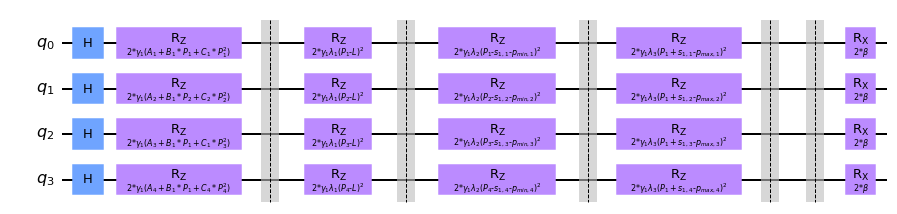

In [8]:
qc_qaoa = QuantumCircuit(nqubits)

qc_qaoa.append(qc_0, [i for i in range(0, nqubits)])
qc_qaoa.append(qc_p, [i for i in range(0, nqubits)])
qc_qaoa.append(qc_mix, [i for i in range(0, nqubits)])

qc_qaoa.decompose().draw("mpl")

Or in more detail

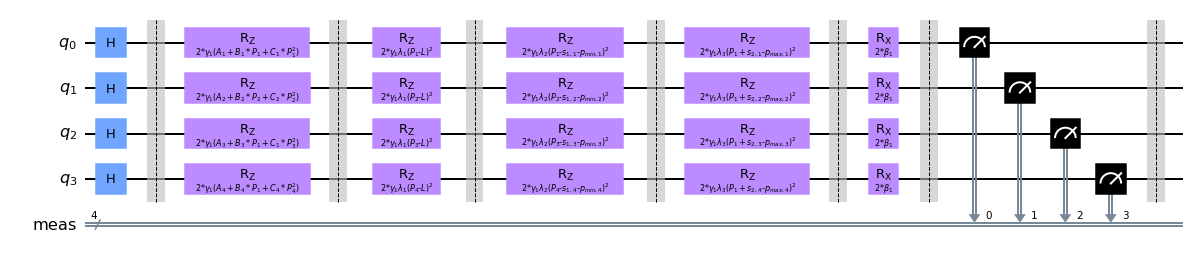

In [9]:
## A brute-Force circuit :)

qr = QuantumRegister(nqubits, 'q')
qc_p = QuantumCircuit(qr)

for i in range(0, nqubits):
    qc_p.h(i)


qc_p.barrier()

# Add the first cost circuit
gammacp1 = Parameter("$  \\gamma_1 (A_1 + B_1*P_1 + C_1* P_{1}^{2})$")
qc_p.rz(2 * gammacp1, qr[0])

gammacp2 = Parameter("$  \\gamma_1 (A_2 + B_2*P_2 + C_2* P_{2}^{2})$")
qc_p.rz(2 * gammacp2, qr[1])

gammacp3 = Parameter("$  \\gamma_1 (A_3 + B_3*P_1 + C_1* P_{3}^{2})$")
qc_p.rz(2 * gammacp3, qr[2])

gammacp4 = Parameter("$  \\gamma_1 (A_4 + B_4*P_1 + C_4* P_{4}^{2})$")
qc_p.rz(2 * gammacp4, qr[3])

qc_p.barrier()
# Add the second cost circuit

gammacl1 = Parameter("$  \\gamma_1 \\lambda_1(P_1 - L)^{2}$")
qc_p.rz(2 * gammacl1, qr[0])

gammacl2 = Parameter("$  \\gamma_1 \\lambda_1(P_2 - L)^{2}$")
qc_p.rz(2 * gammacl2, qr[1])

gammacl3 = Parameter("$  \\gamma_1 \\lambda_1(P_3 - L)^{2}$")
qc_p.rz(2 * gammacl3, qr[2])

gammacl4 = Parameter("$  \\gamma_1 \\lambda_1(P_4 - L)^{2}$")
qc_p.rz(2 * gammacl4, qr[3])

qc_p.barrier()
# Add the third cost circuit
gammacmin1 = Parameter("$  \\gamma_1 \\lambda_2(P_1 - s_{1,1} - p_{min,1})^{2} $")
qc_p.rz(2 * gammacmin1, qr[0])

gammacmin2 = Parameter("$   \\gamma_1 \\lambda_2(P_2 - s_{1,2} - p_{min,2})^{2} $")
qc_p.rz(2 * gammacmin2, qr[1])

gammacmin3 = Parameter("$  \\gamma_1 \\lambda_2(P_3 - s_{1,3} - p_{min,3})^{2} $")
qc_p.rz(2 * gammacmin3, qr[2])

gammacmin4 = Parameter("$  \\gamma_1 \\lambda_2(P_4 - s_{1,4} - p_{min,4})^{2} $")
qc_p.rz(2 * gammacmin4, qr[3])

qc_p.barrier()
# Add the fourth cost circuit

gammacmax1 = Parameter("$  \\gamma_1 \\lambda_3(P_1 + s_{2,1} - p_{max,1})^{2} $")
qc_p.rz(2 * gammacmax1, qr[0])

gammacmax2 = Parameter("$  \\gamma_1 \\lambda_3(P_1 + s_{2,2} - p_{max,2})^{2} $")
qc_p.rz(2 * gammacmax2, qr[1])

gammacmax3 = Parameter("$  \\gamma_1 \\lambda_3(P_1 + s_{2,3} - p_{max,3})^{2} $")
qc_p.rz(2 * gammacmax3, qr[2])

gammacmax4 = Parameter("$  \\gamma_1 \\lambda_3(P_1 + s_{2,4} - p_{max,4})^{2} $")
qc_p.rz(2 * gammacmax4, qr[3])

qc_p.barrier()

# Add the first mixer layer

beta1 = Parameter("$\\beta_1$")


qc_p.rx(2 *beta1, qr)


qc_p.measure_all()

qc_p.barrier()


qc_p.draw("mpl")

# QAOA Implementation

In [10]:
class QUCProblem:
    
    def __init__(self , nodes , lambda1 ,  lambda2 , lambda3, load=1000 ,p=1):
        
        self.nodes = nodes
        self.load = load
        self.lambda1 = lambda1
        self.lambda2 = lambda2
        self.lambda3 = lambda3
        self.p = p  ## depth of the circuit
        
    def maxcut_obj(self , x, G):

        obj = 0
        for i, j in G.edges():
            if x[i] == x[j] and x[i] == "1":
                obj += G.edges[(i,j)]["weight"]

        for i in G.nodes():
            if x[i] == "1":
                obj += G.nodes[i]["weight"]
        return obj


    def compute_expectation(self , counts, G):

        avg = 0
        sum_count = 0
        for bitstring, count in counts.items():

            obj = self.maxcut_obj(bitstring, G)
            avg += obj * count
            sum_count += count

        return avg/sum_count


    def create_qaoa_circ(self , G, theta , power , s1 , s2):

        nqubits = len(G.nodes())
        qc = QuantumCircuit(nqubits)

        beta = theta[:self.p ]
        gamma = theta[self.p :]

        # initial_state
        for i in range(0, nqubits):
            qc.h(i)
        qc.barrier()
        for irep in range(0, self.p):

            # problem unitary
            for nod in list(G.nodes()):
                qc.rz(2 * gamma[irep]*G.nodes[nod]["weight"], nod)  ## we replace weights by the power cost(A+Bp+Cp^2)
                
                ### these corresponds to the constraint lambda_1(P_1 - L)^{2}
                qc.rz(2 * gamma[irep]* (lambda1[nod]*(power[nod] - self.load)**2), nod)
                
                ### these corresponds to the constraint lambda_2(P_1 - s_{1,1} - p_{min,1})^{2}
                qc.rz(2 * gamma[irep]* (lambda2[nod]*(power[nod] - s1[nod] - self.nodes[nod].minCapacity)**2), nod)
                
                ### these corresponds to the constraint lambda_3(P_1 + s_{2,1} - p_{max,1})^{2}
                qc.rz(2 * gamma[irep]* (lambda2[nod]*(power[nod] + s2[nod] - self.nodes[nod].maxCapacity)**2), nod)
                
            qc.barrier()


            # mixer unitary
            for i in range(0, nqubits):
                qc.rx(2 * beta[irep], i)
            qc.barrier()

        qc.measure_all()

        return qc

    # Finally we write a function that executes the circuit on the chosen backend
    def get_expectation(self , G, theta , power , s1 , s2 , backend, shotsin,seed):

        def execute_circ(theta):

            qc = self.create_qaoa_circ(G, theta , power , s1 , s2)

            # We need this step if we want to run on hardware.# tqc = qiskit.compiler.transpile(qc,backend)
            tqc = qc
            print(theta)
            counts = backend.run(tqc, seed_simulator=seed,shots = shotsin).result().get_counts()

            return self.compute_expectation(counts, G)

        return execute_circ

In [11]:


backend = Aer.get_backend('qasm_simulator')



p = 1
theta0 = [1.0, 1.0,1.0,1.0]
##using the fist allocation in the paper
#power = [250.0 , 250.0 , 500.0 , 0.0]

##using the second allocation in the paper
power = [0.0 , 0.0 , 600.0 , 400.0]


s1 = [0.0 , 0.0 , 0.0 , 0.0]
s2 = [0.0 , 0.0 , 0.0 , 0.0]

## these variables are penalizing constraints and are set emprically
lambda1  = [1.0 , 1.0 , 1.0 , 1.0]
lambda2  = [1.0 , 1.0 , 1.0 , 1.0]
lambda3  = [1.0 , 1.0 , 1.0 , 1.0]

quc = QUCProblem(nodes , lambda1 , lambda2 , lambda3 , load = 100.0 , p=1)

# Number of quantum measurements each time the quantum circuit is called
shotsin = 200

seed = 2
maxiter = 100

expectation = quc.get_expectation(G, theta0 , power , s1 , s2 ,backend, shotsin,seed)

options = {'maxiter': maxiter}
res = minimize(expectation,[theta0 , power , s1 , s2],options=options,method='Nelder-Mead')


/tmp/ipykernel_166419/1211650790.py:33: DeprecationWarning: Use of `minimize` with `x0.ndim != 1` is deprecated. Currently, singleton dimensions will be removed from `x0`, but an error will be raised in SciPy 1.11.0.
  res = minimize(expectation,[theta0 , power , s1 , s2],options=options,method='Nelder-Mead')


[  1.   1.   1.   1.   0.   0. 600. 400.   0.   0.   0.   0.   0.   0.
   0.   0.]
[  1.05   1.     1.     1.     0.     0.   600.   400.     0.     0.
   0.     0.     0.     0.     0.     0.  ]
[  1.     1.05   1.     1.     0.     0.   600.   400.     0.     0.
   0.     0.     0.     0.     0.     0.  ]
[  1.     1.     1.05   1.     0.     0.   600.   400.     0.     0.
   0.     0.     0.     0.     0.     0.  ]
[  1.     1.     1.     1.05   0.     0.   600.   400.     0.     0.
   0.     0.     0.     0.     0.     0.  ]
[1.0e+00 1.0e+00 1.0e+00 1.0e+00 2.5e-04 0.0e+00 6.0e+02 4.0e+02 0.0e+00
 0.0e+00 0.0e+00 0.0e+00 0.0e+00 0.0e+00 0.0e+00 0.0e+00]
[1.0e+00 1.0e+00 1.0e+00 1.0e+00 0.0e+00 2.5e-04 6.0e+02 4.0e+02 0.0e+00
 0.0e+00 0.0e+00 0.0e+00 0.0e+00 0.0e+00 0.0e+00 0.0e+00]
[  1.   1.   1.   1.   0.   0. 630. 400.   0.   0.   0.   0.   0.   0.
   0.   0.]
[  1.   1.   1.   1.   0.   0. 600. 420.   0.   0.   0.   0.   0.   0.
   0.   0.]
[1.0e+00 1.0e+00 1.0e+00 1.0e+00 0.0e

[ 1.00608351e+00  1.03832647e+00  1.00576803e+00  1.00726622e+00
 -1.68671965e-05  5.20712578e-05  5.89780486e+02  3.95541360e+02
 -8.71546152e-06  7.35817141e-07 -4.91760042e-07 -2.76329445e-05
  5.61105527e-05  2.72754287e-05 -6.60294204e-06  1.94276025e-05]
[ 1.00653377e+00  1.03847590e+00  1.00527855e+00  1.00687087e+00
 -1.41379813e-05  4.47009934e-05  5.90105386e+02  3.95590136e+02
 -1.21978022e-05  1.71702948e-06 -2.76591483e-06 -2.43276634e-05
  5.63383835e-05  2.89996930e-05 -4.77364978e-06  2.11274454e-05]
[ 1.00663877e+00  1.03869247e+00  1.00558137e+00  1.00775984e+00
 -1.21088711e-05  4.81797717e-05  5.90454560e+02  3.95445063e+02
 -1.10093852e-05  2.11268309e-06 -3.84742304e-06 -2.21802747e-05
  5.82376528e-05  1.64321078e-05 -9.11981205e-06  2.28373895e-05]
[ 1.00599506e+00  1.03822083e+00  1.00469767e+00  1.00945794e+00
 -1.71737645e-05  4.28057111e-05  5.89988626e+02  3.95699920e+02
 -6.42599700e-06  1.26626380e-06 -7.04626123e-07 -2.75835016e-05
  5.47732756e-05  2.61

[ 1.00668624e+00  1.03873372e+00  1.00553484e+00  1.00700232e+00
 -1.54543656e-05  4.55153729e-05  5.88816734e+02  3.95432971e+02
 -6.80511319e-06  3.53344180e-06 -4.27599469e-06 -2.55727856e-05
  6.12405747e-05  2.95382999e-05 -6.17533850e-06  2.23961404e-05]
[ 1.00663568e+00  1.03873212e+00  1.00561046e+00  1.00703643e+00
 -1.56036412e-05  4.54153363e-05  5.88831476e+02  3.95423408e+02
 -6.57257890e-06  3.70945948e-06 -4.08176949e-06 -2.60571078e-05
  6.16340503e-05  2.93282338e-05 -6.48930273e-06  2.23503043e-05]
[ 1.00666908e+00  1.03876328e+00  1.00555986e+00  1.00696673e+00
 -1.55617374e-05  4.53982906e-05  5.88843839e+02  3.95423474e+02
 -6.75328906e-06  3.48057806e-06 -4.01471433e-06 -2.60700043e-05
  6.14772963e-05  2.94272290e-05 -6.34389229e-06  2.23337335e-05]
[ 1.00666042e+00  1.03874696e+00  1.00558287e+00  1.00700257e+00
 -1.57012438e-05  4.54745869e-05  5.88841648e+02  3.95424346e+02
 -6.74336716e-06  3.59438976e-06 -4.12380609e-06 -2.59377978e-05
  6.15096383e-05  2.93

### Analyzing the result

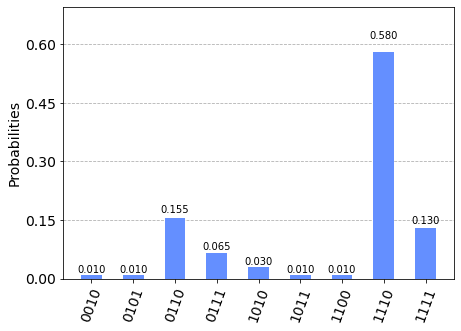

In [12]:

backend = Aer.get_backend('aer_simulator')

qc_res = quc.create_qaoa_circ(G, res.x , power  , s1 , s2)

counts = backend.run(qc_res, seed_simulator=seed,shots = shotsin).result().get_counts()

plot_histogram(counts)

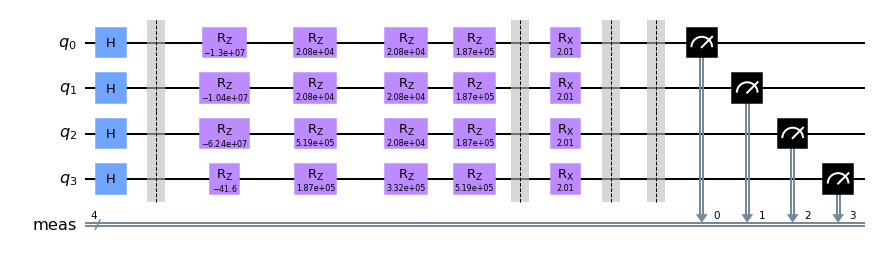

In [13]:
qc_res.draw("mpl")

### Cost

In [14]:
task_price = 0.25 # price for submitting task to system (in dollars)

price_per_CNOT = 0.0001 # price for a single CNOT gate (in dollars)
price_per_Zrot = 0.00003 # price for a single Z rotation (in dollars)
price_per_Xrot = 0.00008 # price for a single X rotation (in dollars)

price_per_shot = p * (len(G.edges()) * (2* price_per_CNOT + price_per_Zrot) + len(G.nodes()) * price_per_Xrot)

Optim_evals = res.nfev # Number of optimization steps i.e. the number of times the quantum hardware was called.
Meas_shots = shotsin # Number of measurements of quantum hardware i.e. number of times the circuit was
# applied to the hardware.

Cost = (Optim_evals * shotsin * price_per_shot) + task_price

print("The estimated cost is = $"+str(Cost))

The estimated cost is = $69.194


### Exact Solution

In this section we find the exact ground state of the above Hamiltonian by finding the eigenstates with the lowest energy. This only works for a small number of qubits, due to the exponential scaling of the computational complexity, but it is useful for benchmarking the QAOA algorithm that we will describe below. 

In [15]:
import numpy as np
import scipy.sparse.linalg as sla
import copy

edges = np.zeros((len(G.edges()),2),dtype=int)
we = np.zeros(len(G.edges()),dtype=float)
iter = 0
for x in G.edges():
    edges[iter,0] = x[0]
    edges[iter,1] = x[1]
    we[iter] = G.edges[x]["weight"]
    iter = iter + 1

wn = np.zeros(len(G.nodes()),dtype=float)
iter = 0
for i in G.nodes():
    wn[iter] = G.nodes[i]["weight"]
    iter = iter + 1

def TensorProd(A):

    out = np.kron(A[0],A[1])
    for oo in range(2,len(A)):
        out = np.kron(out,A[oo])

    return out

sz = [[1.0,0.0],[0.0,0.0]]

A0 = []
for n in range(0,len(nodes)):
    A0.append(np.eye(2))

out = TensorProd(A0)

Ham = np.zeros((np.power(2,len(nodes)),np.power(2,len(nodes))),dtype=float)
for p in range(0,len(nodes)):
    A = copy.deepcopy(A0)
    A[p] = sz
    Ham += wn[p] * TensorProd(A)

for p in range(0,len(G.edges())):
    A = copy.deepcopy(A0)
    A[edges[p][0]] = sz
    A[edges[p][1]] = sz
    Ham += we[p] * TensorProd(A)

Egs_exact, V = sla.eigs(Ham, 1, which='SR')

print("The cost of the optimal solution is "+str(np.real(Egs_exact[0])))

The cost of the optimal solution is -41273866.00000007


In [16]:
## first result :The cost of the optimal solution is -41273866.00000007


## Conclusion (TODO)

Number of gates required is $O(6N*P)$  where $N$ is the number of nodes and $P$ is the depth of the circuit.

## References<a id="references"></a>
[[1] Adapting Quantum Approximation Optimization Algorithm (QAOA) for Unit Commitment
](https://arxiv.org/abs/2110.12624) by Samantha Koretsky et al.